# Velocity gradient time series - Inkjet

Flow: transient nozzle flow with free surface (VoF). Simulation done with OpenFOAM interFoam solver, flow rate data from high speed imaging by Susannah Evans. Uniform time step.

Steps of this script, for each Lagrangian trajectory:

1. Load velocity gradient data
2. De-noise using wavelet hard-thresholding
3. Normalize maximum strain rate (maximum eigenvalue of strain rate tensor), and multiply time by the inverse of this factor.

In [11]:
import numpy as np
from scipy.interpolate import interp1d
import pywt

from ipywidgets import interactive, fixed
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

folder = 'inputs/inkjet'

files = [
    'Lagrangian0.csv',
    'Lagrangian1.csv',
    'Lagrangian2.csv',
    'Lagrangian3.csv',
    'Lagrangian4.csv',
    'Lagrangian5.csv',
    'Lagrangian6.csv',
    'Lagrangian7.csv',
    'Lagrangian8.csv'
]

output_file = 'inputs/inkjet/scenario_inkjet'

## Import velocity gradient data

In [12]:
times = []
gradUs = []
# Pre-normalizing factor (this is properly done later)
f = 0.5e6

for file in files:
    data = np.loadtxt(f'{folder}/{file}', delimiter=',', usecols=list(range(6,15))+[28], skiprows=1) 
    times.append(data[:,-1]*f)
    gradU = data[:,:-1].reshape((len(data), 3, 3))
    # Remove trace
    #trgU = gradU[:,0,0] + gradU[:,1,1] + gradU[:,2,2]
    #gradU = gradU - trgU[:, None, None]/3*np.full_like(gradU, np.eye(3))
    gradUs.append(gradU/f)

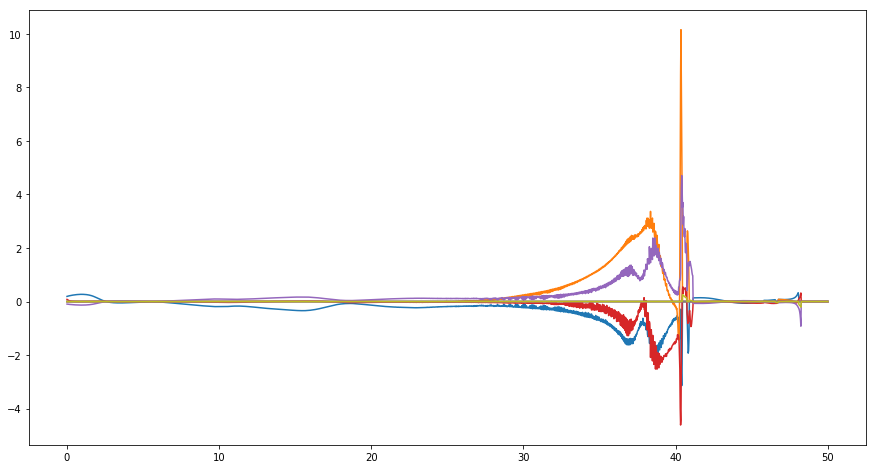

Max trace: 3.947102


In [13]:
plt.plot(times[0], gradUs[0].reshape(len(times[0]),9))
plt.show()
print(f"Max trace: {np.max(gradUs[0][:,0,0]+gradUs[0][:,1,1]+gradUs[0][:,2,2])}")

## Denoise with wavelet

In [28]:
gradUs_denoised = []
wavelet = 'coif2'

# Thresholds
thetas = [
    0.8,
    0.3,
    0.,
    0.,
    0.,
    0.001,
    0.1,
    0,
    0.003
]

for gradU, theta in zip(gradUs, thetas):

    coeffs = pywt.wavedec(gradU, wavelet, mode='antireflect', axis=0)
    for i in range(1,len(coeffs)):
        coeffs[i][np.abs(coeffs[i])<theta] = 0
    #coeffs[-1] = np.zeros_like(coeffs[-1])
    #coeffs[-2] = np.zeros_like(coeffs[-2]) 

    gradUs_denoised.append(pywt.waverec(coeffs, wavelet, mode='antireflect', axis=0))

In [29]:
def zoom(tb, trajectory, line):
    figure, ax = plt.subplots(nrows=2)
    ax[0].plot(gradUs[trajectory][:,line,0], c='#0c2c84')
    ax[0].plot(gradUs_denoised[trajectory][:,line,0], c='#1d91c0', linewidth=2, label='ix')
    ax[0].plot(gradUs[trajectory][:,line,1], c='#1d91c0')
    ax[0].plot(gradUs_denoised[trajectory][:,line,1], c='#7fcdbb', linewidth=2, label='iy')
    ax[0].plot(gradUs[trajectory][:,line,2], c='#7fcdbb')
    ax[0].plot(gradUs_denoised[trajectory][:,line,2], c='#c7e9b4', linewidth=2, label='iz')
    ax[0].legend()
    
    ax[1].plot(gradUs[trajectory][tb[0]:tb[1],line,0], c='#0c2c84')
    ax[1].plot(gradUs_denoised[trajectory][tb[0]:tb[1],line,0], c='#1d91c0', linewidth=2, label='ix')
    ax[1].plot(gradUs[trajectory][tb[0]:tb[1],line,1], c='#1d91c0')
    ax[1].plot(gradUs_denoised[trajectory][tb[0]:tb[1],line,1], c='#7fcdbb', linewidth=2, label='iy')
    ax[1].plot(gradUs[trajectory][tb[0]:tb[1],line,2], c='#7fcdbb')
    ax[1].plot(gradUs_denoised[trajectory][tb[0]:tb[1],line,2], c='#c7e9b4', linewidth=2, label='iz')
    
    ax[1].set_title('Zoom')
    ax[0].axvline(tb[0], c='r')
    ax[0].axvline(tb[1], c='r')
    
    plt.show()


w = interactive(zoom, tb=widgets.IntRangeSlider(
                    value=[0, len(gradUs[0])-1],
                    description='Index range:',
                    min=0,
                    max=len(gradUs[0])-1, 
                    continuous_update=False
                    ),
                     trajectory=widgets.Dropdown(
                    options=list(range(len(gradUs))),
                    value=0,
                    description='Trajectory #:',
                    disabled=False,
                    ),
                    line=widgets.Dropdown(
                    options=[('xx, xy, xz', 0),('yx, yy, yz', 1),('zx, zy, zz', 2)],
                    value=0,
                    description='Line:',
                    disabled=False,
                    )
                
               )
w

interactive(children=(IntRangeSlider(value=(0, 1999), continuous_update=False, description='Index range:', max…

## Remove trace

In [30]:
print(f"Max trace: {np.max(gradUs_denoised[0][:,0,0]+gradUs_denoised[0][:,1,1]+gradUs_denoised[0][:,2,2])}")

for i, gradU in enumerate(gradUs_denoised):
    # Here we don't trust the value zz
    trgU = gradU[:,0,0] + gradU[:,1,1] + gradU[:,2,2]
    gradUs_denoised[i][:,2,2] = - gradU[:,0,0] - gradU[:,1,1]
    
print(f"Max trace: {np.max(gradUs_denoised[0][:,0,0]+gradUs_denoised[0][:,1,1]+gradUs_denoised[0][:,2,2])}")

Max trace: 3.57337461425754
Max trace: 0.0


## Analyse and normalize strain rate

In [31]:
gradUs_norm = []
times_norm = []

for gradU, time in zip(gradUs_denoised, times):

    # Get principal values for the strain
    D = 0.5*(gradU + np.transpose(gradU, axes=(0,2,1)))
    strains = np.linalg.eigvalsh(D)
    max_Wi = np.max(strains[:,2])
    
    # Normalize
    gradUs_norm.append(gradU/max_Wi)
    times_norm.append(time*max_Wi)
    print(f"Maximum strain rate: {max_Wi}")
    print(f"Normalised length of trajecotry: {time[-1]*max_Wi}")

Maximum strain rate: 5.633012498113436
Normalised length of trajecotry: 281.6506249056718
Maximum strain rate: 1.0811116251421726
Normalised length of trajecotry: 54.05558125710863
Maximum strain rate: 0.30859176751692186
Normalised length of trajecotry: 15.429588375846093
Maximum strain rate: 0.40017140728298695
Normalised length of trajecotry: 20.008570364149346
Maximum strain rate: 0.3662604993311653
Normalised length of trajecotry: 18.313024966558263
Maximum strain rate: 0.26682489335481585
Normalised length of trajecotry: 13.341244667740792
Maximum strain rate: 2.5462018130103075
Normalised length of trajecotry: 127.31009065051538
Maximum strain rate: 0.7119848152313726
Normalised length of trajecotry: 35.59924076156863
Maximum strain rate: 0.4110822103485669
Normalised length of trajecotry: 20.554110517428345


## Crop

In [32]:
def crop(tb, trajectory):
    figure, ax = plt.subplots(nrows=2)
    ax[0].plot(times_norm[trajectory], gradUs_norm[trajectory][:,0,0], c='#1d91c0', linewidth=2, label='xx')
    ax[0].plot(times_norm[trajectory], gradUs_norm[trajectory][:,0,1], c='#7fcdbb', linewidth=2, label='xy')
    ax[0].plot(times_norm[trajectory], gradUs_norm[trajectory][:,0,2], c='#c7e9b4', linewidth=2, label='xz')
    ax[0].plot(times_norm[trajectory], gradUs_norm[trajectory][:,1,0], c='#0c2c84', linewidth=2, label='yx')
    ax[0].legend()
    

    ax[1].plot(times_norm[trajectory][tb[0]:tb[1]], gradUs_norm[trajectory][tb[0]:tb[1],0,0], c='#1d91c0', linewidth=2, label='xx')
    ax[1].plot(times_norm[trajectory][tb[0]:tb[1]], gradUs_norm[trajectory][tb[0]:tb[1],0,1], c='#7fcdbb', linewidth=2, label='xy')
    ax[1].plot(times_norm[trajectory][tb[0]:tb[1]], gradUs_norm[trajectory][tb[0]:tb[1],0,2], c='#c7e9b4', linewidth=2, label='xz')
    ax[1].plot(times_norm[trajectory][tb[0]:tb[1]], gradUs_norm[trajectory][tb[0]:tb[1],1,0], c='#0c2c84', linewidth=2, label='yx')
    
    ax[1].set_title('Zoom')
    ax[0].axvline(times_norm[trajectory][tb[0]], c='r')
    ax[0].axvline(times_norm[trajectory][tb[1]], c='r')
    
    plt.show()

#tab_contents
sliders = [widgets.IntRangeSlider(
                    value=[0, len(time)-1],
                    description='Index range:',
                    min=0,
                    max=len(time)-1, 
                    continuous_update=False
                    ) for time in times]

children = [interactive(crop, tb=slider, trajectory=fixed(i)) for i, slider in enumerate(sliders)]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, str(i))
tab

In [34]:
for i, (time, gradU) in enumerate(zip(times_norm, gradUs_norm)):
    tmin, tmax = tab.children[i].kwargs['tb']
    np.savez_compressed(f"{output_file}_{i}", t=time[tmin:tmax]-time[tmin], gradU=gradU[tmin:tmax])